# Medisyn Labs — Data Science Case Study 

**Author:** _Ankita Sinha_  
**Date:** _24-08-2025_

---

## Objectives 
1. Robust, reproducible pipeline with cross-validation, proper train/validation/test set and with data quality issues addressed. 
2. Exploratory analysis, statistically grounded metrics, interpretable features, cluster summaries, and recommendation logic justification.    
3. Solution Provided for each use case with risks/controls addressed.

---

## Use-Cases 
1. **Sentiment Classification** of reviews (Positive vs. Negative).  
2. **Effectiveness Prediction** (5-category multi-class).  
3. **Cohort Discovery** (Clustering similar customers).  
4. **Medicine Recommendation** based on **symptoms/condition** and **past reviews**.

---

## Libraries and Techniques used
- **Python**: `pandas`, `numpy`, `matplotlib`, `scikit-learn` 'sentence transformers`
- **Text**: TF–IDF (with uni/bi-grams), Linear models (SVM/LogReg) for easier interpretability & strong baselines.  
- **Clustering**: Sentence-transformer embeddings to capture semantic meaning of reviews, followed by KMeans clustering with silhouette-based model  
- **Recommendations**: Content-based (condition/query → medicines with similar text features) + Collaborative filtering.  
- **Reproducibility**: Fixed `random_state`, stratified splits, pure transforms within scikit-learn `Pipeline`.  
- **Robustness**: Column standardization, NA handling, configurable thresholds, assertions.


## 1) Setup

Importing libraries, setting global options, and define=ing convenient helpers.  
All plots use **matplotlib** 


In [4]:
#!pip install numpy==1.25.2 pandas==1.5.3 scikit-learn==1.2.2 imbalanced-learn==0.10.1

In [42]:
#!pip install -U sentence-transformers

In [8]:
#!pip install --upgrade typing_extensions

In [11]:
#!pip install "huggingface_hub[hf_xet]"

In [3]:

import os
import re
import math
import json
import joblib
import warnings
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score,
                             roc_auc_score, precision_recall_fscore_support)
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS


from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings('ignore')
RANDOM_STATE = 42

pd.set_option("display.max_colwidth", 220)
pd.set_option("display.width", 180)
print("Libraries imported. Random state =", RANDOM_STATE)


Libraries imported. Random state = 42


## 2) Data Loading & Sanity Checks

We load the provided Train/Test TSV files. The brief states the **exact column order**; to be robust, we:
- Read the header as-is.
- If column names differ slightly (e.g., extra spaces), we **standardize** them to predictable snake_case.
- Validate basic shape and missingness.


In [5]:
import os, re
import csv
import pandas as pd
from pathlib import Path

# --- Configuration ---
BASE_DIR = os.getcwd()
DATA_DIR = os.path.join(BASE_DIR, "..", "Medisyn_Labs_case_study", "Data")
TRAIN_PATH = os.path.join(DATA_DIR, "train.tsv")
TEST_PATH  = os.path.join(DATA_DIR, "test.tsv")

# Original expected headers (human-readable)
EXPECTED_COLS = [
    "Customer Identifier",
    "Medicine Name",
    "Rating",  # 10-star overall satisfaction
    "Effectiveness",  # 5-step categorical
    "Side Effects",   # 5-step categorical
    "Name of condition/illness",
    "Customer Review of benefits",
    "Customer Review of side effects",
    "Overall Customer Review",
]

# --- Utilities ---
def to_snake(s: str) -> str:
    """Converting to snake_case for consistency."""
    return re.sub(r'[^a-z0-9]+','_', s.strip().lower()).strip('_')

def standardize_columns(df, expected_cols=EXPECTED_COLS):
    """Ensuring df has correct headers (snake_case)."""
    if df.shape[1] == len(expected_cols):
        df.columns = expected_cols
    elif df.shape[1] < len(expected_cols):
        # padding with None values
        for i in range(df.shape[1], len(expected_cols)):
            df[i] = None
        df.columns = expected_cols
    elif df.shape[1] > len(expected_cols):
        # merging extra columns into last text col (handles accidental tabs in review column)
        df[len(expected_cols)-1] = df.iloc[:, len(expected_cols)-1:].apply(
            lambda row: " ".join(row.dropna().astype(str)), axis=1
        )
        df = df.iloc[:, :len(expected_cols)]
        df.columns = expected_cols

    # standardize to snake_case
    df.columns = [to_snake(c) for c in df.columns]
    return df

def load_tsv(path, expected_cols):
    """Read TSV without assuming header, then standardize."""
    df = pd.read_csv(
        path,
        sep="\t",
        header=None,        
        quoting=csv.QUOTE_MINIMAL,
        engine="python"
    )
    return standardize_columns(df, expected_cols)

# --- Load data ---
train = load_tsv(TRAIN_PATH, EXPECTED_COLS)
test  = load_tsv(TEST_PATH, EXPECTED_COLS)

print(" Train shape:", train.shape)
print(" Test shape :", test.shape)
print("\nTrain columns:", list(train.columns))

# Quick peek
display(train.head(3))
display(test.head(3))

# --- Sanity checks ---

# Features should overlap between train & test
missing_in_test = set(train.columns) - set(test.columns) 
assert not missing_in_test, f"These feature columns are in train but missing in test: {missing_in_test}"

# Key column checks
assert 'rating' in train.columns, "Expected 'rating' (10-star) not found after standardization."
assert 'overall_customer_review' in train.columns, "Expected overall review text column not found."

print("Train/Test sanity check passed.")
print(f"Train has {train.shape[0]} rows, {train.shape[1]} cols")
print(f"Test  has {test.shape[0]} rows, {test.shape[1]} cols")

 Train shape: (3107, 9)
 Test shape : (1036, 9)

Train columns: ['customer_identifier', 'medicine_name', 'rating', 'effectiveness', 'side_effects', 'name_of_condition_illness', 'customer_review_of_benefits', 'customer_review_of_side_effects', 'overall_customer_review']


,customer_identifier,medicine_name,rating,effectiveness,side_effects,name_of_condition_illness,customer_review_of_benefits,customer_review_of_side_effects,overall_customer_review
0,2202,enalapril,4,Highly Effective,Mild Side Effects,management of congestive heart failure,slowed the progression of left ventricular dysfunction into overt heart failure \r\nalone or with other agents in the managment of hypertension \r\nmangagement of congestive heart failur,"cough, hypotension , proteinuria, impotence , renal failure , angina pectoris , tachycardia , eosinophilic pneumonitis, tastes disturbances , anusease anorecia , weakness fatigue insominca weakness","monitor blood pressure , weight and asses for resolution of fluid"
1,3117,ortho-tri-cyclen,1,Highly Effective,Severe Side Effects,birth prevention,"Although this type of birth control has more cons than pros, it did help with my cramps. It's also effective with the prevention of pregnancy. (Along with use of condoms as well)","Heavy Cycle, Cramps, Hot Flashes, Fatigue, Long Lasting Cycles. It's only been 5 1/2 months, but i'm concidering changing to a different bc. This is my first time using any kind of bc, unfortunately due to the consta...","I Hate This Birth Control, I Would Not Suggest This To Anyone."
2,1146,ponstel,10,Highly Effective,No Side Effects,menstrual cramps,"I was used to having cramps so badly that they would leave me balled up in bed for at least 2 days. The Ponstel doesn't take the pain away completely, but takes the edge off so much that normal activities were possi...",Heavier bleeding and clotting than normal.,"I took 2 pills at the onset of my menstrual cramps and then every 8-12 hours took 1 pill as needed for about 3-4 days until cramps were over. If cramps are bad, make sure to take every 8 hours on the dot because the ..."


,customer_identifier,medicine_name,rating,effectiveness,side_effects,name_of_condition_illness,customer_review_of_benefits,customer_review_of_side_effects,overall_customer_review
0,1366,biaxin,9,Considerably Effective,Mild Side Effects,sinus infection,"The antibiotic may have destroyed bacteria causing my sinus infection. But it may also have been caused by a virus, so its hard to say.","Some back pain, some nauseau.",Took the antibiotics for 14 days. Sinus infection was gone after the 6th day.
1,3724,lamictal,9,Highly Effective,Mild Side Effects,bipolar disorder,"Lamictal stabilized my serious mood swings. One minute I was clawing up the walls in pure mania, the next curled up in a fetal position on my bed contemplating suicdie. I am no longer at the whim of my moods and neit...","Drowsiness, a bit of mental numbness. If you take too much, you will feel sedated. Since you have to be able to clearly and honestly assess your emotions and thoughts, determining how much medication you need is toug...",Severe mood swings between hypomania and depression with suicide ideation before Lamictal. Began with 10mg and tritrated up to 400mg over a few months. Played around with the dosage to finally arrive at 400mg. Experi...
2,3824,depakene,4,Moderately Effective,Severe Side Effects,bipolar disorder,"Initial benefits were comparable to the brand name version of this drug, Depakote. I had been taking Depakote for several months and experienced great results. When I went to my psychiatrist for an evaluation and r...","Depakene has a very thin coating, which caused severe heart burn and stomach upset. The discomfort was so unpleasant that it made me not want to take my meds, so I was not taking them consistently as prescribed. Th...","Depakote was prescribed to me by a Kaiser psychiatrist in Pleasant Hill, CA in 2006. The medication was given to help treat the diagnosis of Bipolar Disorder, Type II. My disease was misdiagnosed for several years ..."


Train/Test sanity check passed.
Train has 3107 rows, 9 cols
Test  has 1036 rows, 9 cols


In [6]:
print("Train columns:", list(train.columns))
print("Test columns:", list(test.columns))

Train columns: ['customer_identifier', 'medicine_name', 'rating', 'effectiveness', 'side_effects', 'name_of_condition_illness', 'customer_review_of_benefits', 'customer_review_of_side_effects', 'overall_customer_review']
Test columns: ['customer_identifier', 'medicine_name', 'rating', 'effectiveness', 'side_effects', 'name_of_condition_illness', 'customer_review_of_benefits', 'customer_review_of_side_effects', 'overall_customer_review']


### 2.1 NA & Duplicate Audit

Quantify missingness by column and check for duplicate rows.  
imputed or dropped later depending on use-case


In [7]:

def na_report(df, name="df"):
    print(f"\nMissing values report: {name}")
    na = df.isna().sum().sort_values(ascending=False)
    display(pd.DataFrame({'column': na.index, 'na_count': na.values, 'na_pct': (na.values/len(df))*100}))

na_report(train, "train")
na_report(test, "test")

# Approximate duplicate detection (customer_id, medicine, condition, rating)
dup_keys = ['customer_identifier', 'medicine_name', 'name_of_condition_illness', 'rating']
dup_count = train.duplicated(subset=[c for c in dup_keys if c in train.columns]).sum()
print(f"\nApprox duplicate rows in train by {dup_keys}: {dup_count}")



Missing values report: train


,column,na_count,na_pct
0,customer_review_of_side_effects,75,2.413904
1,customer_review_of_benefits,18,0.579337
2,overall_customer_review,12,0.386225
3,name_of_condition_illness,1,0.032185
4,customer_identifier,0,0.000000
5,medicine_name,0,0.000000
6,rating,0,0.000000
7,effectiveness,0,0.000000
8,side_effects,0,0.000000



Missing values report: test


,column,na_count,na_pct
0,customer_review_of_side_effects,23,2.220077
1,customer_review_of_benefits,5,0.482625
2,overall_customer_review,1,0.096525
3,customer_identifier,0,0.000000
4,medicine_name,0,0.000000
5,rating,0,0.000000
6,effectiveness,0,0.000000
7,side_effects,0,0.000000
8,name_of_condition_illness,0,0.000000



Approx duplicate rows in train by ['customer_identifier', 'medicine_name', 'name_of_condition_illness', 'rating']: 0


## 3) Exploratory Data Analysis (EDA)
Distributions and relationships critical for downstream modeling:
- Ratings (1–10) distribution and skewness.
- Category frequencies for Effectiveness and Side Effects.
- Top conditions by volume and their average rating.
- Most frequent tokens in positive vs. negative reviews (simple heuristic).

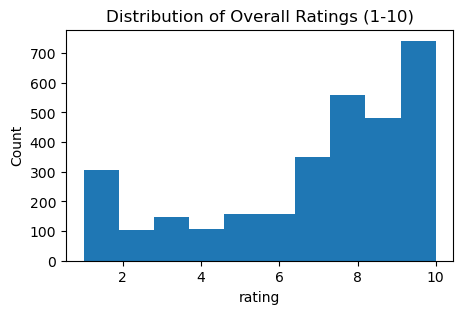

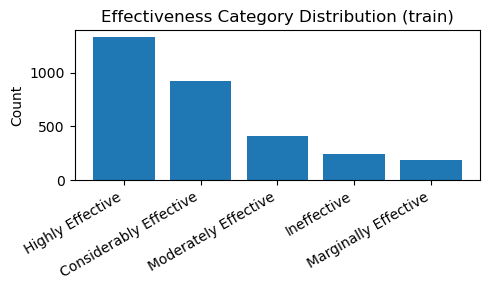

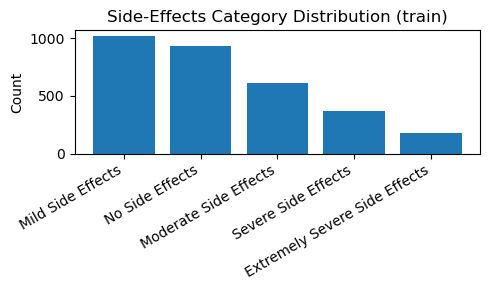

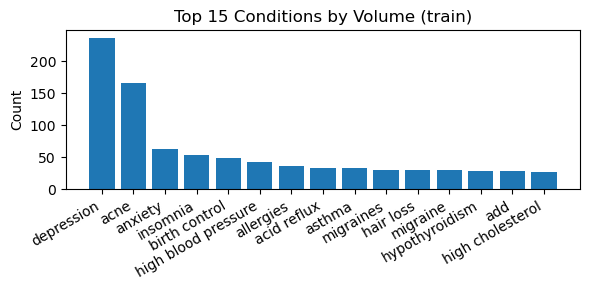

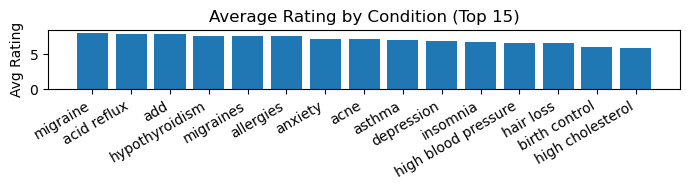


Top tokens (Positive reviews):


,token,count
0,not,1985
1,but,1692
2,day,1515
3,effects,1324
4,taking,1221
5,very,972
6,more,939
7,pain,901
8,drug,895
9,medication,869



Top tokens (Negative reviews):


,token,count
0,not,902
1,but,651
2,day,501
3,effects,492
4,taking,482
5,drug,469
6,pain,456
7,did,431
8,very,347
9,medication,305


In [8]:

def plot_hist(series, title, bins=10):
    plt.figure(figsize=(5,3))
    plt.hist(series.dropna().values, bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.show() 

# 3.1 Rating distribution
if 'rating' in train.columns:
    plot_hist(train['rating'], "Distribution of Overall Ratings (1-10)", bins=10)

# 3.2 Categorical counts
def plot_bar_counts(series, title):
    counts = series.value_counts(dropna=False)
    plt.figure(figsize=(5,3))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

if 'effectiveness' in train.columns:
    plot_bar_counts(train['effectiveness'], "Effectiveness Category Distribution (train)")
if 'side_effects' in train.columns:
    plot_bar_counts(train['side_effects'], "Side-Effects Category Distribution (train)")

# 3.3 Top conditions by volume and average rating
if 'name_of_condition_illness' in train.columns:
    cond_counts = train['name_of_condition_illness'].value_counts().head(15)
    plt.figure(figsize=(6,3))
    plt.bar(cond_counts.index.astype(str), cond_counts.values)
    plt.title("Top 15 Conditions by Volume (train)")
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Avg rating per condition (top 15 by volume)
    top_conds = cond_counts.index.tolist()
    subset = train[train['name_of_condition_illness'].isin(top_conds)]
    avg_by_cond = subset.groupby('name_of_condition_illness')['rating'].mean().sort_values(ascending=False)
    plt.figure(figsize=(7,2))
    plt.bar(avg_by_cond.index.astype(str), avg_by_cond.values)
    plt.title("Average Rating by Condition (Top 15)")
    plt.xticks(rotation=30, ha='right')
    plt.ylabel("Avg Rating")
    plt.tight_layout()
    plt.show()

# 3.4 frequent tokens in positive vs. negative
def simple_tokenize(text, remove_stopwords=True):
    if not isinstance(text, str):
        return []
    tokens = re.findall(r"[a-z']+", text.lower())
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stopwords]
    return tokens


stopwords = set(ENGLISH_STOP_WORDS)
critical_words = {"not", "no", "never", "very", "more", "less",'but'}
stopwords = stopwords - critical_words

text_cols = ['customer_review_of_benefits', 'customer_review_of_side_effects', 'overall_customer_review']
train['all_text'] = train[text_cols].fillna('').agg(' '.join, axis=1)

# Define sentiment label for EDA (>=6 positive)
train['sentiment_label'] = (train['rating'] >= 6).astype(int)

pos_tokens = Counter()
neg_tokens = Counter()

for sent, txt in zip(train['sentiment_label'], train['all_text']):
    toks = simple_tokenize(txt)
    if sent == 1:
        pos_tokens.update(toks)
    else:
        neg_tokens.update(toks)

def top_n(counter, n=20, min_len=3):
    items = [(w,c) for w,c in counter.items() if len(w)>=min_len]
    return sorted(items, key=lambda x: x[1], reverse=True)[:n]

print("\nTop tokens (Positive reviews):")
display(pd.DataFrame(top_n(pos_tokens, 20), columns=["token","count"]))

print("\nTop tokens (Negative reviews):")
display(pd.DataFrame(top_n(neg_tokens, 20), columns=["token","count"]))


**EDA Takeaways **
- Higher rating observed toward higher scores .  
- Effectiveness and side-effects categories correlate with rating.  
- Conditions with abundant data are best candidates for recommender.  


## 3.1) Data Quality Checks
Verifying deeper Data Quality Issues such as :
- Outlier Detection e.g., rating = 100 instead of 1–10, effectiveness = super effective instead of one of 5 allowed values.
- Duplicates - same customer, medicine, and review repeated
- Missing / Corrupted entries - None, empty reviews, incorrect parsing issues
- Imbalanced Labels- check if most reviews are positive (≥6 rating) compared to negative reviews
- Noise in Text - newline characters, HTML tags, very short reviews like “ok” that don’t add signal.

In [9]:
# --- Section 3B: Data Quality Checks ---

print("===== DATA QUALITY CHECKS =====")

# 1. Duplicates
dup_count = train.duplicated().sum()
print(f"Duplicate rows in train: {dup_count}")
if dup_count > 0:
    train = train.drop_duplicates()
    print("Duplicates dropped.")

# 2. Missing values
print("\nMissing values per column:")
print(train.isnull().sum())

# For now, drop rows missing critical info (rating, medicine, condition, review)
critical_cols = ["rating", "medicine_name", "name_of_condition_illness", "overall_customer_review"]
train = train.dropna(subset=critical_cols)

# 3. Outliers in numeric columns
if "rating" in train.columns:
    print("\nRating stats before cleaning:")
    print(train["rating"].describe())

    # Ensure rating is numeric
    train["rating"] = pd.to_numeric(train["rating"], errors="coerce")

    # Drop rows with invalid/missing rating
    train = train.dropna(subset=["rating"])

    # Keep only ratings between 1–10
    train = train[(train["rating"] >= 1) & (train["rating"] <= 10)]
    print("Ratings cleaned to 1–10 range.")

# 4. Value sanity for categorical columns
for col in ["effectiveness", "side_effects"]:
    if col in train.columns:
        print(f"\nUnique values in {col}:")
        print(train[col].value_counts(dropna=False))

# Optional: normalize categorical labels (e.g., lowercasing)
def clean_text_col(series):
    return series.astype(str).str.strip().str.lower()

for col in ["effectiveness", "side_effects"]:
    if col in train.columns:
        train[col] = clean_text_col(train[col])

# 5. Very short or empty reviews (noise)
if "overall_customer_review" in train.columns:
    short_reviews = (train["overall_customer_review"].str.len() < 10).sum()
    print(f"\nRows with very short reviews (<10 chars): {short_reviews}")
    train = train[train["overall_customer_review"].str.len() >= 10]

print("\nData quality checks completed.")
print(f"Train df has {train.shape[0]} rows and {train.shape[1]} columns.")


===== DATA QUALITY CHECKS =====
Duplicate rows in train: 0

Missing values per column:
customer_identifier                 0
medicine_name                       0
rating                              0
effectiveness                       0
side_effects                        0
name_of_condition_illness           1
customer_review_of_benefits        18
customer_review_of_side_effects    75
overall_customer_review            12
all_text                            0
sentiment_label                     0
dtype: int64

Rating stats before cleaning:
count    3094.000000
mean        7.010989
std         2.935101
min         1.000000
25%         5.000000
50%         8.000000
75%         9.000000
max        10.000000
Name: rating, dtype: float64
Ratings cleaned to 1–10 range.

Unique values in effectiveness:
effectiveness
Highly Effective          1325
Considerably Effective     925
Moderately Effective       414
Ineffective                244
Marginally Effective       186
Name: count, dtype: i

## 4) Problem 1 — Sentiment Classification (Positive vs Negative)

**Goal:** Classify overall sentiment of reviews from text.  
**Label:** Based on **Rating** — we use a common threshold: `Rating >= 6 ⇒ Positive (1), else Negative (0)`.

### Why this formulation?
- Aligns with 10-star scale where 6–10 represent overall satisfaction.
- Yields balanced-enough classes typically (verify in data).

### Modeling Options
- **Baseline Modeling Technique:** TF–IDF + LinearSVC (strong linear baseline for high dimensional textual data).    

 - **Approach:**  Using **Pipeline** (clean → transform → train → evaluate) + **GridSearchCV** (Stratified CV) on a train/validation split from the training set, then evaluate on the provided test set.
 - Stratified CV makes sure that in every fold, the proportion of positive vs. negative reviews (or class balance) is the same as in the full dataset. This gives a more fair and stable evaluation


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV F1: 0.8739319994284221

Validation Classification Report (Sentiment):
              precision    recall  f1-score   support

           0      0.758     0.450     0.565       160
           1      0.830     0.949     0.886       453

    accuracy                          0.819       613
   macro avg      0.794     0.700     0.725       613
weighted avg      0.811     0.819     0.802       613



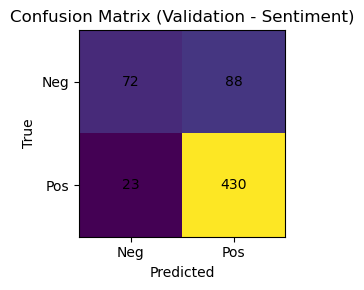

Saved sentiment predictions to predictions_sentiment_test.csv


In [10]:

# Prepare target
train_senti = train.dropna(subset=['rating']).copy()
train_senti['sentiment'] = (train_senti['rating'] >= 6).astype(int)

X = train_senti['all_text'].fillna('')
y = train_senti['sentiment'].values

# Train/validation split
X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

# Pipeline
pipe_senti = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=60000)),
    ('clf', LinearSVC(random_state=RANDOM_STATE))
])

param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
grid_senti = GridSearchCV(pipe_senti, param_grid, cv=cv, n_jobs=-1, scoring='f1', verbose=1)
grid_senti.fit(X_tr, y_tr)

print("Best CV F1:", grid_senti.best_score_)

# Validation performance
va_pred = grid_senti.predict(X_va)
print("\nValidation Classification Report (Sentiment):")
print(classification_report(y_va, va_pred, digits=3))

# Confusion Matrix (Validation)
cm = confusion_matrix(y_va, va_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Validation - Sentiment)")
plt.xticks([0,1], ['Neg','Pos'])
plt.yticks([0,1], ['Neg','Pos'])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Fit on full train and evaluate on provided test set
test['all_text'] = test[['customer_review_of_benefits','customer_review_of_side_effects','overall_customer_review']].fillna('').agg(' '.join, axis=1)
model_senti = grid_senti.best_estimator_
test_pred_senti = model_senti.predict(test['all_text'].fillna(''))

# Save predictions
senti_out = pd.DataFrame({
    'customer_identifier': test.get('customer_identifier', pd.Series(range(len(test)))),
    'predicted_sentiment': test_pred_senti
})
senti_out_path = "predictions_sentiment_test.csv"
senti_out.to_csv(senti_out_path, index=False)
print(f"Saved sentiment predictions to {senti_out_path}")


### 4.1 Interpretability: Most Informative Terms

For linear models, top coefficients indicate which n-grams push predictions toward **Positive** vs **Negative**.


In [11]:

# Extract top features 
try:
    vec = model_senti.named_steps['tfidf']
    clf = model_senti.named_steps['clf']
    feature_names = np.array(vec.get_feature_names_out())

    if hasattr(clf, 'coef_'):
        coefs = clf.coef_.ravel()
        top_pos_idx = np.argsort(coefs)[-20:][::-1]
        top_neg_idx = np.argsort(coefs)[:20]

        top_pos = pd.DataFrame({'term': feature_names[top_pos_idx], 'coef': coefs[top_pos_idx]})
        top_neg = pd.DataFrame({'term': feature_names[top_neg_idx], 'coef': coefs[top_neg_idx]})

        print("Top Positive Terms:")
        display(top_pos)

        print("Top Negative Terms:")
        display(top_neg)
    else:
        print("Classifier has no coef_.")
except Exception as e:
    print("Feature importance extraction failed:", e)


Top Positive Terms:


,term,coef
0,able,1.381473
1,morning,1.183374
2,mild,1.099722
3,needed,1.084255
4,better,1.073208
5,years,1.063637
6,life,1.022558
7,worked,1.004391
8,helped,0.989621
9,daily,0.964247


Top Negative Terms:


,term,coef
0,severe,-2.150263
1,horrible,-1.650065
2,did,-1.610020
3,stopped taking,-1.566135
4,reaction,-1.529223
5,worse,-1.426748
6,stopped,-1.372101
7,stop,-1.274606
8,extreme,-1.272746
9,discontinued,-1.261211


## 5) Problem 2 — Effectiveness Prediction (5-Class Multi-class)

**Goal:** Predict the **Effectiveness** category from text (and optionally rating).  
We treat this as **multi-class text classification**.

### Modeling Design
- Features : Use TF–IDF over combined text.
- Classifier: **LinearSVC** (robust for sparse high dimensional text features) 
- Imbalance Handling: Applied class_weight="balanced" within LinearSVC so minority classes get higher penalty during training
- Handle label encoding consistently (LabelEncoder saved for inference).
- Hyperparameter Tuning: GridSearchCV over C and n-gram ranges.
**Metrics:** `accuracy` and `macro-F1` (to account for class imbalance).


In [18]:
eff_df = train.dropna(subset=['effectiveness']).copy()

X_eff = eff_df['all_text'].fillna('')
le_eff = LabelEncoder()
y_eff = le_eff.fit_transform(eff_df['effectiveness'].astype(str))

X_tr_e, X_va_e, y_tr_e, y_va_e = train_test_split(
    X_eff, y_eff, 
    test_size=0.2, 
    stratify=y_eff, 
    random_state=RANDOM_STATE
)


pipe_eff = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=80000)),
    ('clf', LinearSVC(class_weight="balanced", random_state=RANDOM_STATE))
])

param_grid_eff = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid_eff = GridSearchCV(
    pipe_eff,
    param_grid_eff,
    cv=cv,
    n_jobs=-1,
    scoring='f1_macro',
    verbose=2
)

grid_eff.fit(X_tr_e, y_tr_e)

print("Best params (Effectiveness):", grid_eff.best_params_)
print("Best CV Macro-F1:", grid_eff.best_score_)


# Validation Evaluation

va_pred_eff = grid_eff.predict(X_va_e)

acc = accuracy_score(y_va_e, va_pred_eff)
f1m = f1_score(y_va_e, va_pred_eff, average='macro')

print(f"\nValidation Accuracy (Effectiveness): {acc:.3f}")
print(f"Validation Macro-F1 (Effectiveness): {f1m:.3f}")
print("\nValidation Classification Report (Effectiveness):")
print(classification_report(
    y_va_e, va_pred_eff, 
    target_names=le_eff.classes_, digits=3
))

# Fit on Full Train & Predict on Test

model_eff = grid_eff.best_estimator_

test_eff_text = test['all_text'].fillna('')
test_pred_eff = model_eff.predict(test_eff_text)
test_pred_eff_lbl = le_eff.inverse_transform(test_pred_eff)

eff_out = pd.DataFrame({
    'customer_identifier': test.get('customer_identifier', pd.Series(range(len(test)))),
    'predicted_effectiveness': test_pred_eff_lbl
})

eff_out_path = "predictions_effectiveness_test.csv"
eff_out.to_csv(eff_out_path, index=False)
print(f"Saved effectiveness predictions to {eff_out_path}")

#Persist Label Encoder & Model
joblib.dump(le_eff, "label_encoder_effectiveness.joblib")
joblib.dump(model_eff, "linear_svc_effectiveness_model.joblib")
print("Saved model and label encoder.")


Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best params (Effectiveness): {'clf__C': 0.5, 'tfidf__ngram_range': (1, 1)}
Best CV Macro-F1: 0.3596467711667951

Validation Accuracy (Effectiveness): 0.457
Validation Macro-F1 (Effectiveness): 0.345

Validation Classification Report (Effectiveness):
                        precision    recall  f1-score   support

considerably effective      0.386     0.370     0.378       184
      highly effective      0.552     0.662     0.602       263
           ineffective      0.413     0.396     0.404        48
  marginally effective      0.150     0.083     0.107        36
  moderately effective      0.286     0.195     0.232        82

              accuracy                          0.457       613
             macro avg      0.358     0.341     0.345       613
          weighted avg      0.432     0.457     0.441       613

Saved effectiveness predictions to predictions_effectiveness_test.csv
Saved model and label encoder.


## 6) Problem 3 — Cohort Discovery (Clustering)



## Approach - Using Sentence Transformers

- Load a SentenceTransformer model (all-MiniLM-L6-v2) which is both small and fast.
- Generate vector embeddings.
- Clusters in embedding space (semantic cohorts)
- Uses cosine silhouette to pick k
- Fits MiniBatchKMeans on L2-normalized embeddings (spherical k-means)
- Visualizes with PCA 
- Explains clusters by computing TF-IDF on the reviews inside each cluster to extract top terms to keep interpretability

In [19]:
### GENERATE EMBEDDINGS
from sentence_transformers import SentenceTransformer

# Load model
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Use combined text (same as before)
texts = train['all_text'].fillna('').astype(str).tolist()

# Generate embeddings
X_all = embedder.encode(texts, batch_size=64, show_progress_bar=True)


Batches:   0%|          | 0/48 [00:00<?, ?it/s]

k=3 silhouette=0.0509
k=4 silhouette=0.0512
k=5 silhouette=0.0514
k=6 silhouette=0.0382
k=7 silhouette=0.0312
k=8 silhouette=0.0354
Selected k for clustering: 5


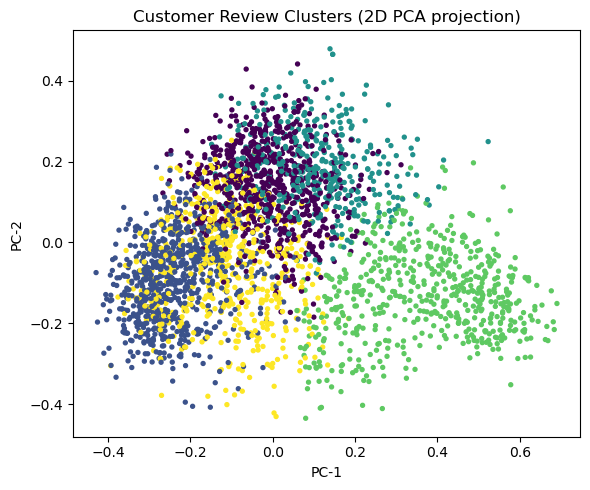

Cluster Summaries:


,cluster,count,avg_rating,top_conditions,sample_reviews
1,1,772,7.136010,"{'depression': 204, 'insomnia': 53, 'anxiety': 50, 'depression/anxiety': 16, 'bipolar disorder': 11}",[I had began taking 20mg of Vyvanse for three months and was surprised to find that such a small dose affected my mood so effectively. When it came to school work though I found that I needed the 30mg to increase my...
0,0,750,6.852000,"{'acid reflux': 25, 'high cholesterol': 23, 'migraine': 16, 'arthritis': 16, 'rheumatoid arthritis': 16}","[I Hate This Birth Control, I Would Not Suggest This To Anyone., I took 2 pills at the onset of my menstrual cramps and then every 8-12 hours took 1 pill as needed for about 3-4 days until cramps were over. If cramps..."
3,3,571,7.220665,"{'acne': 155, 'birth control': 17, 'hair loss': 15, 'wrinkles': 15, 'rosacea': 14}",[For the first 6-8 weeks I used one drop every night applied to upper lash base with a small disposable brush. After my lashes had grown in I started using it every 2-3 nights instead of every night and the lashes h...
4,4,569,7.022847,"{'high blood pressure': 34, 'depression': 26, 'hypothyroidism': 23, 'birth control': 19, 'add': 17}","[monitor blood pressure , weight and asses for resolution of fluid, one pill once daily, Switched from Adderall to Dexedrine to compare the effects. Dexedrine is simply dextroamphetamine while Adderall is a mixture o..."
2,2,400,6.872500,"{'allergies': 35, 'asthma': 25, 'sinus infection': 18, 'sinusitis': 8, 'bronchitis': 6}","[took one 10 mg pill nightly., I took the antibiotic as prescribed every day, twice a day, one pill each time. My Bacterial Vaginosis cleared up after treatment. However, I did have a slight yeast infection that went..."


In [12]:
# Sample subset for silhouette  
n_samples = min(15000, len(X_all))
sample_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_all), size=n_samples, replace=False)
X_sample = [X_all[i] for i in sample_idx]

sil_scores = []
k_values = list(range(3, 9))
for k in k_values:
    km = MiniBatchKMeans(n_clusters=k, random_state=RANDOM_STATE, batch_size=4096)
    labels = km.fit_predict(X_sample)
    sil = silhouette_score(X_sample, labels)
    sil_scores.append(sil)
    print(f"k={k} silhouette={sil:.4f}")

# Pick best k
best_k = k_values[int(np.argmax(sil_scores))]
print("Selected k for clustering:", best_k)

# Fit on all data with best_k
kmeans = MiniBatchKMeans(n_clusters=best_k, random_state=RANDOM_STATE, batch_size=4096)
clusters_all = kmeans.fit_predict(X_all)
train['cluster'] = clusters_all

# 2D projection for visualization (using PCA on embeddings)
from sklearn.decomposition import PCA
X_2d = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(X_all)

plt.figure(figsize=(6,5))
plt.scatter(X_2d[:,0], X_2d[:,1], c=train['cluster'], s=8)
plt.title("Customer Review Clusters (2D PCA projection)")
plt.xlabel("PC-1")
plt.ylabel("PC-2")
plt.tight_layout()
plt.show()

# Cluster summaries 
summaries = []
for c in range(best_k):
    mask = (train['cluster'] == c)
    sub = train[mask]
    avg_rating = sub['rating'].mean()
    top_cond = sub['name_of_condition_illness'].value_counts().head(5).to_dict()
    summaries.append({
        'cluster': c,
        'count': int(mask.sum()),
        'avg_rating': float(avg_rating) if not math.isnan(avg_rating) else None,
        'top_conditions': top_cond,
       
        'sample_reviews': sub['overall_customer_review'].head(3).tolist()
    })

summary_df = pd.DataFrame(summaries).sort_values('count', ascending=False)
print("Cluster Summaries:")
display(summary_df)


## 7) Problem 4 — Medicine Recommendation


`Approach` : Designed a Hybrid Recommender System that combines two complementary strategies — Content-Based Filtering (medicine relevance to condition) and Collaborative Filtering (personalization from user–medicine ratings).

### Content-Based (Condition/Symptom → Similar Medicines)
- Build a TF–IDF representation of aggregated reviews per medicine.
- For a given user query (symptom/condition text), compute cosine similarity to retrieve the most relevant medicines.
- Apply a minimum review threshold per medicine to ensure recommendations are based on robust evidence.

### Simple Collaborative Filtering (User–Item Ratings)
- Construct a **Customer × Medicine** rating matrix using historical `Rating`data.
- Use user–user similarity (cosine similarity) to identify similar patients and recommend medicines that worked well for them.
- Captures hidden patterns

In [36]:
from sklearn.preprocessing import MinMaxScaler

def hybrid_recommend(
    user_id, query, df_group, vec, X, user_item, user_item_filled,
    alpha=0.5, top_n=10
):
    """
    Hybrid recommender combining Content-Based (query-text) + Collaborative Filtering (user ratings).
    
    Inputs:
        user_id : customer identifier
        query   : symptom/condition text
        df_group, vec, X → from content-based pipeline
        user_item, user_item_filled → from collaborative pipeline
        alpha   :  weight for content (0.0–1.0)
        top_n   :  number of recommendations
    """
    # Content-Based Filtering Scores
    qv = vec.transform([query])
    sims = cosine_similarity(qv, X).ravel()
    cbf_scores = pd.Series(sims, index=df_group['medicine_name'])
    
    # Collaborative Filtering Scores
    if user_id not in user_item.index:
        print(f"User {user_id} not found in CF matrix — fallback to content only.")
        cf_scores = pd.Series(0, index=df_group['medicine_name'])
    else:
        # Normalize rows
        A = user_item_filled.values
        norms = np.linalg.norm(A, axis=1, keepdims=True)
        norms[norms == 0] = 1.0
        A_norm = A / norms
        
        # Find neighbors for this user
        users = user_item_filled.index.tolist()
        uidx = users.index(user_id)
        sims_u = A_norm @ A_norm[uidx].T  # cosine similarity
        sims_series = pd.Series(sims_u, index=users).drop(user_id).sort_values(ascending=False)
        
        # Weighted score for items the user hasn't rated
        user_row = user_item.loc[user_id]
        not_rated = user_row[user_row.isna()].index.tolist()

        weighted_scores = {}
        top_k_neighbors = sims_series.head(50)
        for item in not_rated:
            neigh_ratings = user_item[item].dropna()
            common = neigh_ratings.index.intersection(top_k_neighbors.index)
            if len(common) == 0 or top_k_neighbors.loc[common].sum() == 0:
                # fallback to CBF score
                weighted_scores[item] = cbf_scores.get(item, 0)
            else:
                score = np.average(neigh_ratings.loc[common].values, weights=top_k_neighbors.loc[common].values)
                weighted_scores[item] = score

        cf_scores = pd.Series(weighted_scores).reindex(df_group['medicine_name']).fillna(0)

    # Combining Scores
    scaler = MinMaxScaler()
    cbf_scaled = pd.Series(
        scaler.fit_transform(cbf_scores.values.reshape(-1,1)).ravel(),
        index=cbf_scores.index
    )
    cf_scaled = pd.Series(
        scaler.fit_transform(cf_scores.values.reshape(-1,1)).ravel(),
        index=cf_scores.index
    )

    final_scores = alpha * cbf_scaled + (1 - alpha) * cf_scaled
    recs = final_scores.sort_values(ascending=False).head(top_n).reset_index()
    recs.columns = ['medicine_name', 'hybrid_score']
    
    return recs


In [45]:
# Choose a sample user
try:
    sample_user = str(user_counts.index[1])  
    query = "cold relief with less side effects and no drowsiness"  

    hybrid_recs = hybrid_recommend(
        user_id=sample_user,
        query=query,
        df_group=med_group_global,
        vec=vec_med_global,
        X=X_med_global,
        user_item=user_item,
        user_item_filled=user_item_filled,
        alpha=0.6,  # 60% content, 40% collaborative
        top_n=10
    )

    print(f"Hybrid recommendations for user {sample_user}:")
    display(hybrid_recs)
except Exception as e:
    print(f"Unexpected Error occurred: {str(e)}")


Hybrid recommendations for user 3453:


,medicine_name,hybrid_score
0,valtrex,1.000000
1,acyclovir,0.990390
2,zomig,0.616252
3,flexeril,0.546920
4,vicodin,0.517837
5,fiorinal,0.490822
6,zyrtec,0.482614
7,allegra,0.454565
8,percocet,0.446563
9,duragesic,0.423735


## 8) Risks and Controls

**Risks/Assumptions**
- **Labeling for Sentiment** uses `Rating >= 6` as a proxy for positivity.
- **Category Imbalance** can bias multi-class effectiveness. Mitigated via macro-F1; further balancing (class weights - explored) & resampling can be further explored.
- **Text Noise** (typos, slang) reduces signal. I used TF–IDF n-grams; sentence transformer embeddings.
- **Cold Start** in recommendations: content-based handles new medicines better than CF.
- **Data Leakage**: Restricted modeling decisions to train data; test set is only used for final evaluation/predictions.

**Controls**
- **Pipelines** encapsulate all transforms; reproducible with saved parameters.
- **Cross-Validation** for robust hyperparameter selection.
- **Explainability** via top n-grams and cluster summaries.
- **Artifacts**: Predictions saved to CSV for quick evaluation.



> **Outputs:** Look for CSV files named `predictions_sentiment_test.csv` and `predictions_effectiveness_test.csv` in your working directory.
